In [1]:
import os
import glob
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
POSITIVE_DIR = "/content/DDS1/PP/IMAGE"
NEGATIVE_DIR = "/content/DDS1/NP/IMAGE"

# Global Params
IMG_WIDTH = 40
IMG_HEIGHT = 40
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

TEST_SPLIT_SIZE = 0.2
VALIDATION_SPLIT = 0.2
EPOCHS = 30
BATCH_SIZE = 32
DROPOUT_RATE = 0.2 # Best dropout

In [3]:
def load_and_preprocess_images(positive_dir, negative_dir):
    images = []
    labels = []

    print(f"Loading images from: {positive_dir} (Label 1)")
    pos_files = glob.glob(os.path.join(positive_dir, "*.bmp"))
    print(f"Found {len(pos_files)} positive images.")

    for img_path in pos_files:
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            images.append(img_resized)
            labels.append(1)
        except Exception as e: pass

    print(f"Loading images from: {negative_dir} (Label 0)")
    neg_files = glob.glob(os.path.join(negative_dir, "*.bmp"))
    print(f"Found {len(neg_files)} negative images.")

    for img_path in neg_files:
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            images.append(img_resized)
            labels.append(0)
        except Exception as e: pass

    print("Converting to NumPy arrays and normalizing...")
    images_np = np.array(images, dtype="float32") / 255.0
    labels_np = np.array(labels, dtype="int32")
    return images_np, labels_np

In [4]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_winning_model(input_shape, dropout_rate):
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Initial Conv
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ResNet-10 Blocks
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 256, stride=2)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    feature_output = layers.Dense(128, activation='relu', name='feature_layer')(x)
    x = layers.Dropout(dropout_rate)(feature_output)
    classifier_output = layers.Dense(1, activation='sigmoid', name='classifier_head')(x)

    model = keras.Model(inputs=inputs, outputs=classifier_output, name="ResNet10_Hero")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [5]:
def run_resnet():
    print(f"--- STARTING RUN (ResNet-10, Dropout {DROPOUT_RATE}) ---")

    # Load Data
    try:
        all_images, all_labels = load_and_preprocess_images(POSITIVE_DIR, NEGATIVE_DIR)
    except Exception as e:
        print(f"Error loading images: {e}")
        return

    if len(all_images) == 0: return

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        all_images, all_labels, test_size=TEST_SPLIT_SIZE, stratify=all_labels, random_state=42
    )

    # Build Model
    model = build_winning_model(IMG_SHAPE, DROPOUT_RATE)

    # Class Weights (1:4)
    class_weights_dict = {0: 1.0, 1: 4.0}

    # Early Stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Give it 5 epochs to improve
        restore_best_weights=True
    )

    # Train
    print("\nTraining ResNet Model...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        class_weight=class_weights_dict,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate
    print("\nEvaluating on Test Set...")
    preds_proba = model.predict(X_test).ravel()
    preds_class = (preds_proba > 0.5).astype(int)

    # Metrics
    final_auc = roc_auc_score(y_test, preds_proba)
    final_f1 = f1_score(y_test, preds_class)
    final_acc = accuracy_score(y_test, preds_class)

    print("\n=== FINAL RESNET MODEL RESULTS ===")
    print(f"AUC Score: {final_auc:.5f}")
    print(f"F1 Score:  {final_f1:.5f}")
    print(f"Accuracy:  {final_acc:.5f}")

    print("\nClassification Report:")
    print(classification_report(y_test, preds_class, target_names=['Negative', 'Positive']))

    plot_confusion_matrix(y_test, preds_class, "ResNet-10 Confusion Matrix")

--- STARTING RUN (ResNet-10, Dropout 0.2) ---
Loading images from: /content/DDS1/PP/IMAGE (Label 1)
Found 2636 positive images.
Loading images from: /content/DDS1/NP/IMAGE (Label 0)
Found 28848 negative images.
Converting to NumPy arrays and normalizing...

Training ResNet Model...
Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.9380 - loss: 0.3002 - val_accuracy: 0.9843 - val_loss: 0.0466
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9846 - loss: 0.0803 - val_accuracy: 0.9369 - val_loss: 0.1814
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9890 - loss: 0.0577 - val_accuracy: 0.9833 - val_loss: 0.0487
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9920 - loss: 0.0467 - val_accuracy: 0.9764 - val_loss: 0.0753
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9910 - loss: 0.0443 - val_accuracy: 0.9857 - val_loss: 0.0466
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9925 - lo

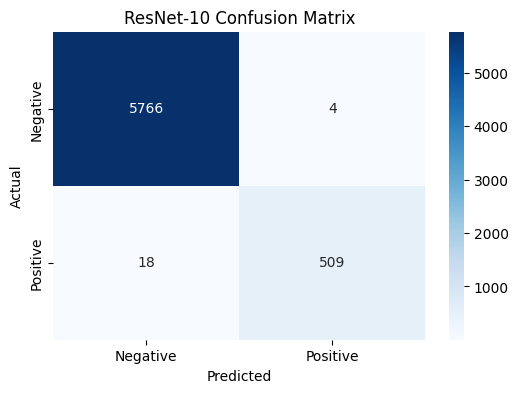

In [6]:
if __name__ == "__main__":
    run_resnet()

In [11]:
from IPython.display import display

hero_data = {
    'Metric': [
        'AUC Score',
        'F1-Score (Positive)',
        'Recall (Sensitivity)',
        'Precision (Positive)',
        'Overall Accuracy'
    ],
    'Value': [
        0.9997,  # AUC
        0.9789,  # F1 Score
        0.9700,  # Recall for Positive Class (from report)
        0.9900,  # Precision for Positive Class (from report)
        0.9965   # Accuracy
    ]
}

# Create DataFrame
df_hero = pd.DataFrame(hero_data)

# Transpose it so it looks like a summary row

hero_data_horizontal = {
    'Model Configuration': ['ResNet-10 (Dropout 0.2)'],
    'AUC': [0.9997],
    'F1-Score': [0.9789],
    'Recall': [0.9700],
    'Precision': [0.9900],
    'Accuracy': [0.9965]
}

df_hero_final = pd.DataFrame(hero_data_horizontal)

# Display table
print("--- Table II: Final Validated Model Performance ---")
display(df_hero_final.style.hide(axis='index') # Hides the '0' index number
        .background_gradient(cmap='Greens', subset=['AUC', 'F1-Score', 'Recall'])
        .format("{:.4f}", subset=['AUC', 'F1-Score', 'Recall', 'Precision', 'Accuracy']))

--- Table II: Final Validated Model Performance ---


Model Configuration,AUC,F1-Score,Recall,Precision,Accuracy
ResNet-10 (Dropout 0.2),0.9997,0.9789,0.9700,0.9900,0.9965
